# How to: Create and Use a FeatureSet

The `FeatureSet` is the central data container in ModularML. It organizes your data into three domains:

- **Features**: model inputs (e.g., time-series signals, sensor readings)
- **Targets**: values to predict (e.g., state-of-health, capacity)
- **Tags**: metadata for grouping and filtering (e.g., cell ID, temperature)

Under the hood, a `FeatureSet` wraps a `SampleCollection`, which stores all data in a columnar [Apache Arrow](https://arrow.apache.org/) table. Each column follows the naming convention `<domain>.<key>.<representation>` (e.g., `features.voltage.raw`). A `SampleSchema` tracks the structure, shapes, and data types.

This notebook covers the complete `FeatureSet` API:

1. [Creating a FeatureSet](#1-creating-a-featureset)
2. [Inspecting a FeatureSet](#2-inspecting-a-featureset)
3. [Accessing Data](#3-accessing-data)
4. [Row Subsetting and Filtering](#4-row-subsetting-and-filtering)
5. [Column Subsetting](#5-column-subsetting)
6. [Splitting Data](#6-splitting-data)
7. [Transforms / Scaling](#7-transforms--scaling)
8. [Serialization (Save / Load)](#8-serialization-save--load)
9. [References (for Model Graph Wiring)](#9-references-for-model-graph-wiring)

In [1]:
import numpy as np
import pandas as pd

import modularml as mml
from modularml import FeatureSet

We'll use synthetic battery pulse-response data throughout this notebook. Each sample contains a 101-point voltage time-series, a scalar state-of-health (SOH) target, and metadata tags.

In [2]:
N_SAMPLES = 1000
N_CELLS = 20
N_GROUPS = 5
TIME = np.linspace(0, 100, 101)

rng = np.random.default_rng(42)

# Assign each sample a cell, group, pulse type, and SOC
cell_ids = rng.integers(1, N_CELLS + 1, size=N_SAMPLES)
group_ids = rng.integers(1, N_GROUPS + 1, size=N_SAMPLES)
pulse_types = rng.choice(["chg", "dchg"], size=N_SAMPLES)
pulse_socs = rng.choice([10, 20, 30, 40, 50, 60, 70, 80, 90], size=N_SAMPLES)

# SOH degrades with group_id (higher group = more degraded)
soh = 100.0 - (group_ids - 1) * 8.0 + rng.normal(0, 2, size=N_SAMPLES)

# Synthetic voltage: baseline + pulse shape, shifted by SOC and degraded by SOH
voltage = np.zeros((N_SAMPLES, 101))
for i in range(N_SAMPLES):
    base = 3.2 + pulse_socs[i] / 100.0 * 0.5
    amplitude = 0.3 * (soh[i] / 100.0)
    sign = 1.0 if pulse_types[i] == "chg" else -1.0
    curve = sign * amplitude * (1 - np.exp(-TIME / 15.0))
    voltage[i] = base + curve + rng.normal(0, 0.002, size=101)

data = {
    "voltage": voltage.tolist(),
    "soh": soh.tolist(),
    "cell_id": cell_ids.tolist(),
    "group_id": group_ids.tolist(),
    "pulse_type": pulse_types.tolist(),
    "pulse_soc": pulse_socs.tolist(),
}

print(f"Samples: {N_SAMPLES}")
print(f"Voltage shape per sample: {voltage[0].shape}")
print(f"SOH range: [{soh.min():.1f}, {soh.max():.1f}]")

Samples: 1000
Voltage shape per sample: (101,)
SOH range: [63.1, 106.1]


---
## 1. Creating a FeatureSet

Three class methods are available for construction.

### `from_dict()` — From a Python dictionary

The most common constructor. Pass a dict where each key maps to a list/array of values (one entry per sample), then specify which keys are features, targets, and tags.

In [3]:
fs = FeatureSet.from_dict(
    label="PulseData",
    data=data,
    feature_keys="voltage",
    target_keys="soh",
    tag_keys=["cell_id", "group_id", "pulse_type", "pulse_soc"],
)
print(fs)
print(f"Feature shapes: {fs.get_feature_shapes()}")
print(f"Target shapes:  {fs.get_target_shapes()}")

FeatureSet(label='PulseData', n_samples=1000)
Feature shapes: {'features.voltage.raw': (101,)}
Target shapes:  {'targets.soh.raw': ()}


When accessing FeatureSet data, you'll notice that all keys are returned in the `<domain>.<key>.<representation>` by default.
You can modify the the returned string with the `include_rep_suffix` and `include_domain_prefix` arguments in all `FeatureSet.get_<>` methods.

*Note that certain string-component omissions will raise an error if it results in a non-unique key (e.g., you have two representations of the same feature column)*

In [4]:
print(f"Feature shapes: {fs.get_feature_shapes(include_domain_prefix=False, include_rep_suffix=False)}")

Feature shapes: {'voltage': (101,)}


### `from_pandas()` — From a Pandas DataFrame

Allows for FeatureSet structuring directly from a Pandas DataFrame.
We similarly need to assign column names to features, targets, and tags.

In [5]:
# Create a simple DataFrame example
df = pd.DataFrame({
    "temperature": np.random.default_rng(0).normal(25, 5, size=100),
    "humidity": np.random.default_rng(1).normal(60, 10, size=100),
    "output_power": np.random.default_rng(2).normal(100, 15, size=100),
    "site_id": np.repeat(["A", "B", "C", "D"], 25),
    "timestamp": np.arange(25).tolist() * 4,
})

fs_from_df = FeatureSet.from_pandas(
    label="WeatherData",
    df=df,
    feature_cols=["temperature", "humidity"],
    target_cols="output_power",
    tag_cols="site_id",
)
print(fs_from_df)
print(f"Feature shapes: {fs_from_df.get_feature_shapes()}")

FeatureSet(label='WeatherData', n_samples=100)
Feature shapes: {'features.temperature.raw': (), 'features.humidity.raw': ()}


Note that the above approach treats every row in the dataframe as a unique sample for modeling.

If that's not the case, grouping will need to be performed to aggregate rows in the Pandas dataframe belonging to each sample.
The `from_pandas` constructor provides the `group_by` and `sort_by` arguments to do just that.

Below, we group all rows in our dataframe by the `'site_id'` at which the data was measured, and then ensure all data points are sorted by `'time_stamp'` within each sample. Notice how the feauture now have a shape of (25,).

In [6]:
fs_grouped = FeatureSet.from_pandas(
    label="WeatherGrouped",
    df=df,
    feature_cols=["temperature", "humidity"],
    target_cols="output_power",
    group_by="site_id",
    sort_by="timestamp",
    tag_cols=["site_id", "timestamp"],
)
print(fs_grouped)
print(f"Feature shapes: {fs_grouped.get_feature_shapes()}")

FeatureSet(label='WeatherGrouped', n_samples=4)
Feature shapes: {'features.temperature.raw': (25,), 'features.humidity.raw': (25,)}


### `from_pyarrow_table()` — From an Arrow table

If you already have a `pyarrow.Table` with columns following the `<domain>.<key>.<rep>` naming convention, you can wrap it directly.

*Unless you are certain that the existing table uses the appropriate schema, it is recommended to use `table.to_pandas()`, then use the `from_pandas()` constructor.*


In [7]:
import pyarrow as pa

table = pa.table({
    "features.x.raw": [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]],
    "targets.y.raw": [0.5, 1.5],
    "tags.group.raw": ["a", "b"],
})

fs_arrow = FeatureSet.from_pyarrow_table(label="ArrowExample", table=table)
print(fs_arrow)
print(f"Feature shapes: {fs_arrow.get_feature_shapes()}")

FeatureSet(label='ArrowExample', n_samples=2)
Feature shapes: {'features.x.raw': (3,)}


---
## 2. Inspecting a FeatureSet

Use the following properties and methods to understand the structure of your data.

In [8]:
# Basic info
print(f"Label:      {fs.label}")
print(f"Samples:    {len(fs)}")
print(f"repr:       {fs!r}")

Label:      PulseData
Samples:    1000
repr:       FeatureSet(label='PulseData', n_samples=1000)


In [9]:
# Column keys by domain
print("Feature keys:", fs.get_feature_keys())
print("Target keys: ", fs.get_target_keys())
print("Tag keys:    ", fs.get_tag_keys())

Feature keys: ['features.voltage.raw']
Target keys:  ['targets.soh.raw']
Tag keys:     ['tags.cell_id.raw', 'tags.group_id.raw', 'tags.pulse_soc.raw', 'tags.pulse_type.raw']


In [10]:
# All keys with full qualification (domain prefix + rep suffix)
fs.get_all_keys(include_domain_prefix=True, include_rep_suffix=True)

['features.voltage.raw',
 'targets.soh.raw',
 'tags.cell_id.raw',
 'tags.group_id.raw',
 'tags.pulse_soc.raw',
 'tags.pulse_type.raw',
 'sample_uuids']

In [11]:
# Shapes and dtypes
print("Feature shapes:", fs.get_feature_shapes())
print("Target shapes: ", fs.get_target_shapes())
print("Tag shapes:    ", fs.get_tag_shapes())
print()
print("Feature dtypes:", fs.get_feature_dtypes())
print("Target dtypes: ", fs.get_target_dtypes())

Feature shapes: {'features.voltage.raw': (101,)}
Target shapes:  {'targets.soh.raw': ()}
Tag shapes:     {'tags.cell_id.raw': (), 'tags.group_id.raw': (), 'tags.pulse_type.raw': (), 'tags.pulse_soc.raw': ()}

Feature dtypes: {'features.voltage.raw': 'float64'}
Target dtypes:  {'targets.soh.raw': 'float64'}


Note that most data containing classes in ModularML also support a `summary()` method.

Printing the results provides a formatted summary of all characteristics of that object.

In [12]:
print(fs.summary())

┌─ FeatureSet ────────────────────────────────────────────────────────────────┐
│ label : PulseData                                                           │
│ n_samples : 1000                                                            │
│ columns :                                                                   │
│   features : ['voltage.raw']                                                │
│   targets : ['soh.raw']                                                     │
│   tags : ['cell_id.raw', 'group_id.raw', 'pulse_soc.raw', 'pulse_type.raw'] │
│ splits : []                                                                 │
└─────────────────────────────────────────────────────────────────────────────┘


---
## 3. Accessing Data

Data can be retrieved in multiple formats via the `fmt` parameter. Accepted values include `"numpy"`, `"pandas"`, `"dict_numpy"`, `"torch"`, and more.

### Domain-specific accessors

In [13]:
# Get all features as a dict of numpy arrays (default)
features = fs.get_features()
print(f"Type: {type(features)}")
print(f"Keys: {list(features.keys())}")
print(f"Voltage shape: {features['voltage'].shape}")

Type: <class 'dict'>
Keys: ['voltage']
Voltage shape: (1000, 101)


In [14]:
# Get a single feature by name, as numpy
voltage = fs.get_features(fmt="numpy", features="voltage")
print(f"Shape: {voltage.shape}")

Shape: (1000, 1, 101)


In [15]:
# Get targets as a pandas DataFrame
targets_df = fs.get_targets(fmt="pandas")
targets_df.head()

,soh
0,65.950942
1,77.816126
2,81.594607
3,67.427268
4,98.827897


In [16]:
# Get specific tags as a dict of numpy arrays
tags = fs.get_tags(fmt="dict_numpy", tags=["cell_id", "pulse_type"])
print(f"Type: {type(tags)}")
print(f"Cell IDs (first 5): {tags['cell_id'][:5]}")
print(f"Pulse types (first 5): {tags['pulse_type'][:5]}")

Type: <class 'dict'>
Cell IDs (first 5): [ 2 16 14  9  9]
Pulse types (first 5): ['dchg' 'chg' 'chg' 'chg' 'dchg']


### Unified accessor: `get_data()`

Retrieve columns from multiple domains in a single call. Supports wildcards and a default `rep` parameter.

In [17]:
# Specific columns from different domains
result = fs.get_data(
    features="voltage",
    targets="soh",
    tags="*",
    fmt="pandas",
)
result.head()

,features.voltage.raw,targets.soh.raw,tags.cell_id.raw,tags.group_id.raw,tags.pulse_soc.raw,tags.pulse_type.raw
0,"[3.5979637647769627, 3.5883023211547314, 3.575...",65.950942,2,5,80,dchg
1,"[3.5491166164116543, 3.564106763808909, 3.5777...",77.816126,16,4,70,chg
2,"[3.6494730454996422, 3.6628728757569684, 3.679...",81.594607,14,3,90,chg
3,"[3.6482468703516338, 3.6623709038524175, 3.675...",67.427268,9,5,90,chg
4,"[3.5503312243004657, 3.5307669820685303, 3.508...",98.827897,9,1,70,dchg


In [18]:
# Sample UUIDs - each sample has a unique identifier
uuids = fs.get_sample_uuids()
print(f"First 3 UUIDs: {uuids[:3]}")

First 3 UUIDs: ['9933fccc-3a83-4aeb-bfa1-7024dd7c3292'
 '2d184086-96ca-4edf-a59c-b4404acc6dd3'
 'a646005e-2707-4c4e-9232-a2170ed09568']


### Export to pandas or Arrow

In [19]:
# Full export to pandas
df_all = fs.to_pandas()
df_all

,features.voltage.raw,targets.soh.raw,tags.cell_id.raw,tags.group_id.raw,tags.pulse_soc.raw,tags.pulse_type.raw,sample_uuids
0,"[3.5979637647769627, 3.5883023211547314, 3.575...",65.950942,2,5,80,dchg,9933fccc-3a83-4aeb-bfa1-7024dd7c3292
1,"[3.5491166164116543, 3.564106763808909, 3.5777...",77.816126,16,4,70,chg,2d184086-96ca-4edf-a59c-b4404acc6dd3
2,"[3.6494730454996422, 3.6628728757569684, 3.679...",81.594607,14,3,90,chg,a646005e-2707-4c4e-9232-a2170ed09568
3,"[3.6482468703516338, 3.6623709038524175, 3.675...",67.427268,9,5,90,chg,70ff6f21-3844-4516-842a-a4e928ba5c3a
4,"[3.5503312243004657, 3.5307669820685303, 3.508...",98.827897,9,1,70,dchg,dc8cb042-54ef-4662-87de-62c176cb77a7
...,...,...,...,...,...,...,...
995,"[3.399637885900285, 3.3808574406740917, 3.3631...",97.660648,13,1,40,dchg,0de6976a-097d-4cc9-8ecb-9d22cbd10f0a
996,"[3.248430899684502, 3.2653723118726536, 3.2820...",85.509724,11,3,10,chg,7302f946-674a-46d8-af59-34fb0216af14
997,"[3.596808282265428, 3.613550267972738, 3.62288...",67.410862,8,5,80,chg,f41264b4-e694-420a-bca8-e083979cde54
998,"[3.5497847714709616, 3.5686142719690186, 3.582...",86.967810,20,2,70,chg,9b736d19-a1cc-49af-b87a-96fd64604d56


In [20]:
# Export to Arrow table
arrow_table = fs.to_arrow()
print(f"Arrow schema:\n{arrow_table.schema}")

Arrow schema:
features.voltage.raw: list<item: double>
  child 0, item: double
targets.soh.raw: double
tags.cell_id.raw: int64
tags.group_id.raw: int64
tags.pulse_soc.raw: int64
tags.pulse_type.raw: string
sample_uuids: string
-- schema metadata --
modularml.features.voltage.raw.shape: '(101,)'
modularml.features.voltage.raw.dtype: 'float64'
modularml.targets.soh.raw.shape: '()'
modularml.targets.soh.raw.dtype: 'float64'
modularml.tags.cell_id.raw.shape: '()'
modularml.tags.cell_id.raw.dtype: 'int64'
modularml.tags.group_id.raw.shape: '()'
modularml.tags.group_id.raw.dtype: 'int64'
modularml.tags.pulse_type.raw.shape: '()'
modularml.tags.pulse_type.raw.dtype: 'string'
modularml.tags.pulse_soc.raw.shape: '()'
modularml.tags.pulse_soc.raw.dtype: 'int64'
modularml.version: '1.0.0'


---
## 4. Row Subsetting and Filtering

All row-subsetting operations return a `FeatureSetView` - a lightweight, zero-copy window over the parent `FeatureSet`.

### `filter()` — Condition-based filtering

Conditions are a dict mapping fully-qualified column names to:
- A **scalar** (equality match)
- A **list/set** (membership test)
- A **callable** (row-wise predicate)

In [21]:
# Filter by equality
view_chg = fs.filter(conditions={"tags.pulse_type.raw": "chg"})
print(f"Charge-only: {view_chg}")
print(np.unique(view_chg.get_tags(fmt="np", tags="pulse_type")))

Charge-only: FeatureSetView(source='PulseData', n_samples=508, label='PulseData_view')
['chg']


In [22]:
# Filter by list membership
view_cells = fs.filter(conditions={"tags.cell_id.raw": [1, 2, 3]})
print(f"Cells 1-3: {view_cells}")
print(np.unique(view_cells.get_tags(fmt="np", tags="cell_id")))

Cells 1-3: FeatureSetView(source='PulseData', n_samples=161, label='PulseData_view')
[1 2 3]


In [23]:
# Filter with callable + multiple conditions (AND-composed)
view_healthy_chg = fs.filter(conditions={
    "tags.pulse_type.raw": "chg",
    "targets.soh.raw": lambda x: x >= 90.0,
})
print(f"Healthy charge pulses: {view_healthy_chg}")

Healthy charge pulses: FeatureSetView(source='PulseData', n_samples=187, label='PulseData_view')


### `take()` — By relative index

In [24]:
view_first10 = fs.take([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], label="first_10")
print(view_first10)

FeatureSetView(source='PulseData', n_samples=10, label='first_10')


### `take_sample_uuids()` — By UUID

In [25]:
some_uuids = fs.get_sample_uuids()[:5].tolist()
view_by_uuid = fs.take_sample_uuids(some_uuids, label="uuid_subset")
print(view_by_uuid)

FeatureSetView(source='PulseData', n_samples=5, label='uuid_subset')


### Set operations between views

In [26]:
# Intersection: samples in both views
view_a = fs.filter(conditions={"tags.pulse_type.raw": "chg"})
print("View A:")
print(" - view:", view_a)
print(" - cells:", np.unique(view_a.get_tags(fmt="np", tags="cell_id")))
print(" - pulse_types:", np.unique(view_a.get_tags(fmt="np", tags="pulse_type")))

view_b = fs.filter(conditions={"tags.cell_id.raw": [1, 2, 3]})
print("\nView B:")
print(" - view:", view_b)
print(" - cells:", np.unique(view_b.get_tags(fmt="np", tags="cell_id")))
print(" - pulse_types:", np.unique(view_b.get_tags(fmt="np", tags="pulse_type")))


view_intersect = view_a.take_intersection(view_b, label="chg_cells_1to3")
print("\nIntersection:")
print(" - view:", view_intersect)
print(" - cells:", np.unique(view_intersect.get_tags(fmt="np", tags="cell_id")))
print(" - pulse_types:", np.unique(view_intersect.get_tags(fmt="np", tags="pulse_type")))

# Difference: samples in A but not in B
view_diff = view_a.take_difference(view_b, label="chg_not_cells_1to3")
print("\nDifference:")
print(" - view:", view_diff)
print(" - cells:", np.unique(view_diff.get_tags(fmt="np", tags="cell_id")))
print(" - pulse_types:", np.unique(view_diff.get_tags(fmt="np", tags="pulse_type")))


View A:
 - view: FeatureSetView(source='PulseData', n_samples=508, label='PulseData_view')
 - cells: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
 - pulse_types: ['chg']

View B:
 - view: FeatureSetView(source='PulseData', n_samples=161, label='PulseData_view')
 - cells: [1 2 3]
 - pulse_types: ['chg' 'dchg']

Intersection:
 - view: FeatureSetView(source='PulseData', n_samples=79, label='chg_cells_1to3')
 - cells: [1 2 3]
 - pulse_types: ['chg']

Difference:
 - view: FeatureSetView(source='PulseData', n_samples=429, label='chg_not_cells_1to3')
 - cells: [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
 - pulse_types: ['chg']


We can also check view overlap via the `is_disjoint_with` method.

In [27]:
print("view_diff does not contain view_b samples: ", view_b.is_disjoint_with(view_diff))

view_diff does not contain view_b samples:  True


### Converting a view back to a FeatureSet

A `FeatureSetView` is a lightweight reference of indices in the parent FeatureSet. 
Any modification to the FeatureSet with change the data access through its child views.

To create an independent `FeatureSet` from a view, use `to_featureset()`:

In [28]:
fs_charge = view_chg.to_featureset(label="ChargePulses")
print(fs_charge)

FeatureSet(label='ChargePulses', n_samples=508)


---
## 5. Column Subsetting

Use `select()` to create a view with only specific columns. Row indices are preserved.

Select supports the same wildcard usage as `filter()`

In [29]:
# Select specific features and targets
view_slim = fs.select(features="voltage.*", targets="soh")
print(f"Columns: {view_slim.get_all_keys()}")

Columns: ['features.voltage.raw', 'targets.soh.raw', 'sample_uuids']


In [30]:
# Select by domain and representation
view_raw_only = fs.select(features="voltage", rep="raw")
print(f"Columns: {view_raw_only.get_all_keys(include_domain_prefix=True, include_rep_suffix=True)}")

Columns: ['features.voltage.raw', 'sample_uuids']


---
## 6. Splitting Data

Splitting creates named `FeatureSetView` partitions that are registered (optional) on the parent FeatureSet.

### Random splitting

Random splitting takes a `ratios` argument, defining the proportions of all samples in the calling container to be assigned to each key.
The ratio values must add up to 1.

By default, splits views are not returned and automatically registered to the parent FeatureSet.
This behaviour can be specified via the `return_views` and `register` arguments.

In [31]:
fs_charge.clear_splits()
fs_charge.split_random(
    ratios={"train": 0.6, "val": 0.2, "test": 0.2},
    seed=42,
)

print(f"Available splits: {fs_charge.available_splits}")
for name, view in fs_charge.splits.items():
    print(f"  {name}: {len(view)} samples")

Available splits: ['train', 'val', 'test']
  train: 305 samples
  val: 102 samples
  test: 101 samples


Use `group_by` to keep all samples sharing a tag value in the same split (prevents data leakage):

In [32]:
fs_charge.clear_splits()

fs_charge.split_random(
    ratios={"train": 0.5, "val": 0.3, "test": 0.2},
    group_by="group_id",
    seed=1,
)

for name, view in fs_charge.splits.items():
    group_ids = view.get_tags(fmt="numpy", tags="group_id")
    print(f"  {name}: {len(view)} samples, groups: {np.unique(group_ids)}")

  train: 296 samples, groups: [1 2 5]
  val: 124 samples, groups: [3]
  test: 88 samples, groups: [4]


Use `stratify_by` to ensure all splits have representative distributions of the calling source.

Note that grouping and stratification are mutually exclusive (you can't use both at the same time).

In [33]:
fs_charge.clear_splits()

fs_charge.split_random(
    ratios={"train": 0.5, "val": 0.3, "test": 0.2},
    stratify_by="group_id",
    seed=1,
)

for name, view in fs_charge.splits.items():
    group_ids = view.get_tags(fmt="numpy", tags="group_id")
    print(f"  {name}: {len(view)} samples, groups: {np.unique(group_ids)}")

  train: 255 samples, groups: [1 2 3 4 5]
  val: 152 samples, groups: [1 2 3 4 5]
  test: 101 samples, groups: [1 2 3 4 5]


### Condition-based splitting

Assign samples to splits using explicit conditions on any column.

Condition-based splitting takes a `condition` argument, which is a nested dict of: `{split_name: {column: condition}}`.

Samples that satisfy all conditions within the named split are returned in the split. 
A warning will be thrown if the produces splits are not mutually exclusive.

In [34]:
fs_charge.clear_splits()

fs_charge.split_by_condition({
    "train": {"tags.group_id.raw": [1, 2, 3]},
    "val":   {"tags.group_id.raw": [4]},
    "test":  {"tags.group_id.raw": [5]},
})

for name, view in fs_charge.splits.items():
    group_ids = view.get_tags(fmt="numpy", tags="group_id")
    print(f"  {name}: {len(view)} samples, groups: {np.unique(group_ids)}")

  train: 323 samples, groups: [1 2 3]
  val: 88 samples, groups: [4]
  test: 97 samples, groups: [5]


### Nested splits

Splitting can be called on any existing split, in addition to directly on the parent FeatureSet.
The nested split conditions will only draw from the samples available in the calling view.

This allows us to "nest" split conditions to create more complex modeling setups.

*Note that the sub-splits will inherently overlap with the calling view, and care should be taking when using these splits in downstream modeling.*

In [35]:
fs_charge.clear_splits()

fs_charge.split_by_condition({
    "source": {
        "targets.soh": lambda soh: soh >= 90,
        "tags.group_id.raw": [1,2,3],
    },
    "test":  {
        "targets.soh": lambda soh: soh < 90,
        "tags.group_id.raw": [4,5],
    },
})
fs_charge.get_split("source").split_random(
    ratios={"train": 0.8, "val":0.2},
    stratify_by="group_id",
)

for name, view in fs_charge.splits.items():
    group_ids = view.get_tags(fmt="numpy", tags="group_id")
    print(f"  {name}: {len(view)} samples, groups: {np.unique(group_ids)}")

  source: 187 samples, groups: [1 2]
  test: 185 samples, groups: [4 5]
  train: 150 samples, groups: [1 2]
  val: 37 samples, groups: [1 2]


### Getting splits directly with `return_views`

In [36]:
fs_charge.clear_splits()

# Build custom views using any filter logic
train_view = fs_charge.filter(
    conditions={
        "tags.group_id.raw": [1, 2, 3],
        "targets.soh.raw": lambda x: x >= 80.0,
    },
    label="train",
)
test_view = fs_charge.filter(
    conditions={"tags.group_id.raw": [4, 5]},
    label="test",
)

# Register them as named splits
fs_charge.add_split(train_view)
fs_charge.add_split(test_view)

for name, view in fs_charge.splits.items():
    print(f"  {name}: {len(view)} samples")

  train: 322 samples
  test: 185 samples


Let's restore a simple train/val/test for scaling

In [37]:
fs_charge.clear_splits()

split_views = fs_charge.split_random(
    ratios={"train": 0.6, "val": 0.2, "test": 0.2},
    group_by="group_id",
    seed=42,
    return_views=True,
)

for name, view in split_views.items():
    print(f"  {name}: {len(view)} samples")

  train: 309 samples
  val: 92 samples
  test: 107 samples


Note that most ModularML core classes implement a `.visualize()` method.
For FeatureSets, this displays a Mermaid diagram of all splits registered to the FeatureSet.

*Note that you will need to install a Mermaid rendering extension for your IDE. I use "Markdown Preview Mermaid Support".*

In [39]:
fs_charge.visualize(show_overlaps=False)

```mermaid
flowchart LR
	n0 e0@-->|"n=309"| n1
	n0 e1@-->|"n=92"| n2
	n0 e2@-->|"n=107"| n3

	n0@{ label: "<b>FeatureSet</b><br>'ChargePulses'<br>n=508<br>──────────<br><b>features</b><br>  voltage.raw: (101,)<br><b>targets</b><br>  soh.raw: ()<br><b>tags</b><br>  cell_id.raw: ()<br>  group_id.raw: ()<br>  pulse_soc.raw: ()<br>  pulse_type.raw: ()", shape: rect }
	n1@{ label: "<b>Split</b><br>'train'<br>n=309<br>──────────<br><b>features</b><br>  voltage.raw: (101,)<br><b>targets</b><br>  soh.raw: ()", shape: rect }
	n2@{ label: "<b>Split</b><br>'val'<br>n=92<br>──────────<br><b>features</b><br>  voltage.raw: (101,)<br><b>targets</b><br>  soh.raw: ()", shape: rect }
	n3@{ label: "<b>Split</b><br>'test'<br>n=107<br>──────────<br><b>features</b><br>  voltage.raw: (101,)<br><b>targets</b><br>  soh.raw: ()", shape: rect }
	n0:::FeatureSet
	n1:::FeatureSetView
	n2:::FeatureSetView
	n3:::FeatureSetView
	classDef FeatureSet stroke-width: 2px, stroke-dasharray: 0, stroke: #AA00FF, fill: #E1BEE7, color:#000000;
	classDef FeatureSetView stroke-width: 2px, stroke-dasharray: 0, stroke: #AA00FF, fill: #F3E5F5, color:#000000;

	classDef NoAnimation stroke-dasharray: 0;
	class e0 NoAnimation
	class e1 NoAnimation
	class e2 NoAnimation
```

---
## 7. Transforms / Scaling

Apply preprocessing transforms to features or targets. Transforms are tracked and can be undone.

Several scalers are built into to ModularML and accessible via the `Scaler.get_supported_scalers()` command.
You can also create custom scalers, as outlined below.

In [ ]:
# List all available scalers
mml.supported_scalers

{'StandardScaler': sklearn.preprocessing._data.StandardScaler,
 'MinMaxScaler': sklearn.preprocessing._data.MinMaxScaler,
 'MaxAbsScaler': sklearn.preprocessing._data.MaxAbsScaler,
 'RobustScaler': sklearn.preprocessing._data.RobustScaler,
 'Normalizer': sklearn.preprocessing._data.Normalizer,
 'QuantileTransformer': sklearn.preprocessing._data.QuantileTransformer,
 'PowerTransformer': sklearn.preprocessing._data.PowerTransformer,
 'Absolute': modularml.scalers.absolute.Absolute,
 'Negate': modularml.scalers.negate.Negate,
 'PerSampleMinMaxScaler': modularml.scalers.per_sample_min_max.PerSampleMinMaxScaler,
 'PerSampleZeroStart': modularml.scalers.per_sample_zero.PerSampleZeroStart,
 'SegmentedScaler': modularml.scalers.segmented_scaler.SegmentedScaler}

Let's create a little utility to plot our voltages so we can verify our transforms:

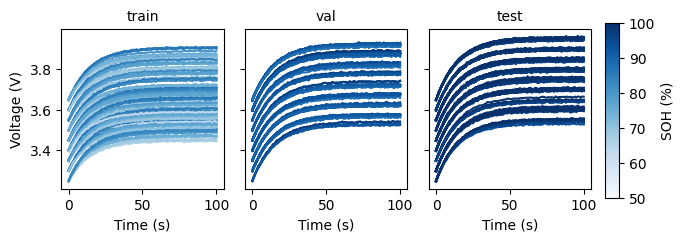

In [ ]:
import matplotlib.pyplot as plt


def plot_voltages(fs: FeatureSet, n_samples: int = 200, rep: str = "transformed", seed: int = 13):
    """
    Plot the 'voltage' feature contained in the FeatureSet.

    Each split will get its own panel.
    Colors by SOH (dark blue = high SOH, light blue = low SOH)

    Args:
        fs (FeatureSet): FeatureSet to use.
        n_samples (int, optional): The number of samples in `fs` that will
              get plotted. Defaults to 200.
        rep (str): The representation of the data to plot (eg, "raw" and "transformed")
        seed (int, optional): A seed to ensure the same samples get plotted
              with repeated calls. Defaults to 13.

    """
    def order_splits(values: list[str]) -> list[str]:
        priority = {"train": 0, "val": 1, "test": 2}
        return sorted(values, key=lambda x: priority.get(x, 99))

    rng = np.random.default_rng(seed)
    scm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=50, vmax=100))

    # Verify rep exists
    avail_reps = fs.collection._get_rep_keys(domain="features", key="voltage")
    if rep not in avail_reps:
        rep = "raw"

    # Create figure with panels for each split
    fig, axes = plt.subplots(figsize=(7, 2.5), ncols=fs.n_splits, sharex=True, sharey=True)
    split_names = order_splits(fs.available_splits)
    for i, split_label in enumerate(split_names):
        # For each split, get all voltage features and group_ids
        split_view = fs.get_split(split_label)
        voltages = np.squeeze(split_view.get_features(features="voltage", fmt="numpy", rep=rep))
        sohs = np.squeeze(split_view.get_targets(targets="soh", fmt="numpy", rep="raw"))

        # Select n_samples
        sample_idxs = rng.choice(np.arange(0, len(voltages)), size=n_samples)
        for idx in sample_idxs:
            axes[i].plot(voltages[idx], color=scm.to_rgba(sohs[idx]))

        axes[i].set_title(split_label, fontsize=10)
        axes[i].set_xlabel("Time (s)", fontsize=10)
    axes[0].set_ylabel("Voltage (V)", fontsize=10)

    # Adjust main subplot area to leave space on the right for colorbar
    fig.tight_layout(pad=1)
    fig.subplots_adjust(right=0.85)

    # Add colorbar as a dedicated panel on the far right
    cbar_ax = fig.add_axes([0.87, 0.19, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(scm, cax=cbar_ax)
    cbar.set_label("SOH (%)", fontsize=10)
    return fig, axes

fig, axes = plot_voltages(fs_charge, n_samples=200)
plt.show()

### Applying a transform

`fit_transform()` fits a scaler and stores the result as a `"transformed"` representation alongside the original `"raw"` data.

- `domain`: `"features"` or `"targets"`
- `keys`: which keys to transform (default: all in domain)
- `fit_to_split`: fit only on this split's data (prevents data leakage)

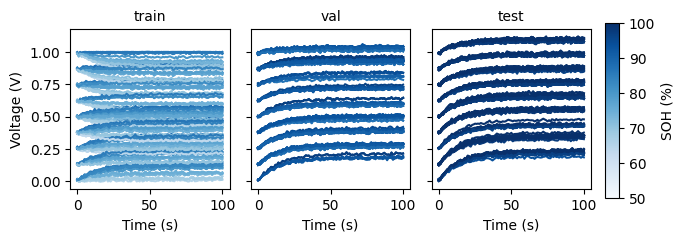

In [ ]:
from modularml import Scaler

# Apply MinMaxScaler to voltage, fitted on training data only
fs_charge.fit_transform(
    scaler=Scaler("MinMaxScaler"),
    domain="features",
    keys="voltage",
    fit_to_split="train",
)

# Raw data is preserved - access both representations
raw = fs_charge["train"].get_features(fmt="numpy", features="voltage", rep="raw")
transformed = fs_charge["train"].get_features(fmt="numpy", features="voltage", rep="transformed")

fig, axes = plot_voltages(fs_charge, n_samples=200, rep="transformed")
plt.show()

### Chaining transforms

Multiple transforms can be applied sequentially. Each call transforms the current `"transformed"` representation.

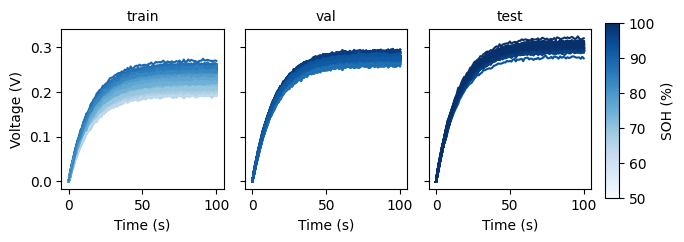

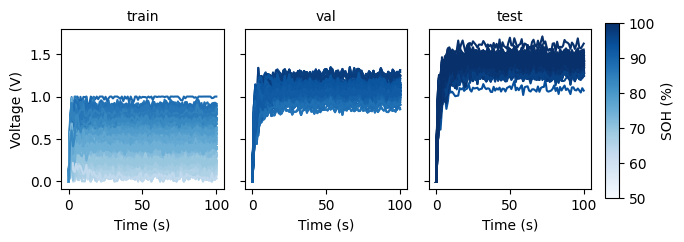

In [ ]:
# First undo, then chain: zero-start -> min-max
fs_charge.undo_all_transforms(domain="features")

fs_charge.fit_transform(
    scaler="PerSampleZeroStart",
    domain="features",
    keys="voltage",
    fit_to_split="train",
)

fig, axes = plot_voltages(fs_charge, n_samples=200, rep="transformed")
plt.show()

fs_charge.fit_transform(
    scaler="MinMaxScaler",
    domain="features",
    keys="voltage",
    fit_to_split="train",
)

fig, axes = plot_voltages(fs_charge, n_samples=200, rep="transformed")
plt.show()

### Scaling targets

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# You can also pass sklearn instances directly
fs_charge.fit_transform(
    scaler=MinMaxScaler(),
    domain="targets",
    keys="soh",
    fit_to_split="train",
)

soh_raw = fs_charge["test"].get_targets(fmt="numpy", targets="soh", rep="raw")
soh_scaled = fs_charge["test"].get_targets(fmt="numpy", targets="soh", rep="transformed")
print(f"SOH raw range:     [{soh_raw.min():.1f}, {soh_raw.max():.1f}]")
print(f"SOH scaled range:  [{soh_scaled.min():.3f}, {soh_scaled.max():.3f}]")

SOH raw range:     [93.9, 106.1]
SOH scaled range:  [1.170, 1.636]


### Undoing transforms

In [ ]:
# Undo the last *feature* transform (MinMaxScaler), keeping PerSampleZeroStart
# Note that the target transform (although more recent) is not inversed
fs_charge.undo_last_transform(domain="features", keys="voltage")

transformed = fs_charge["train"].get_features(fmt="numpy", features="voltage", rep="transformed")
print("After undo last:")
print(f"  min={transformed.min():.4f} (should be ~0.0)")
print(f"  max={transformed.max():.4f} (no longer bounded to 1.0)")

print(f"SOH:  [{soh_scaled.min():.3f}, {soh_scaled.max():.3f}]")

After undo last:
  min=0.0000 (should be ~0.0)
  max=0.2745 (no longer bounded to 1.0)
SOH:  [1.170, 1.636]


In [ ]:
# Undo all transforms in a domain
fs_charge.undo_all_transforms()

# Verify: after undoing all, 'transformed' rep no longer exists
print("Keys after undo:", fs_charge.get_all_keys(include_domain_prefix=True, include_rep_suffix=True))

Keys after undo: ['features.voltage.raw', 'targets.soh.raw', 'tags.cell_id.raw', 'tags.group_id.raw', 'tags.pulse_soc.raw', 'tags.pulse_type.raw', 'sample_id']


### Inverse-scaling external data

Use `unscale_data_for_cols()` to apply inverse transforms to data that lives outside the FeatureSet (e.g., model predictions):

In [ ]:
fs_charge.fit_transform(
    scaler=MinMaxScaler(),
    domain="targets",
    keys="soh",
    fit_to_split="train",
)

# Simulate model predictions in scaled space
fake_predictions = np.array([[0.5], [0.8], [0.2]])

# Inverse-transform back to original SOH scale
original_scale = fs_charge.unscale_data_for_cols(
    data=fake_predictions,
    domain="targets",
    columns="soh",
)
print(f"Scaled predictions:   {fake_predictions.ravel()}")
print(f"Original-scale SOH:   {original_scale.ravel()}")

Scaled predictions:   [0.5 0.8 0.2]
Original-scale SOH:   [76.26473547 84.15067632 68.37879462]


While you can access the fit scalers on a particular column and use for unscaling (shown above), it is best practice to use the original FeatureSet, filter to the sample IDs on which your scaled data was produced, and then access the "transformed" version directly. This is the only way to fully guarantee that you are "applying" the correct scaler. 

We'll cover this more in depth in: 
TODO: $\textcolor{red}{\text{add notebook link to "working with model outputs / results"}}$

---
## 8. Serialization (Save / Load)

FeatureSets can be saved to disk and fully restored, including splits and transforms.

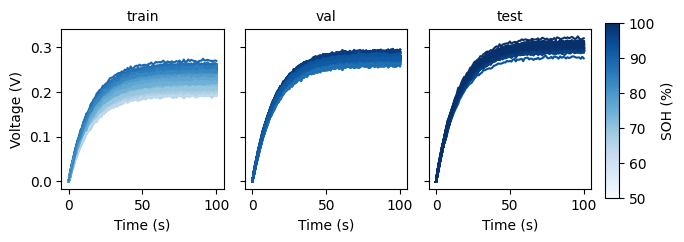

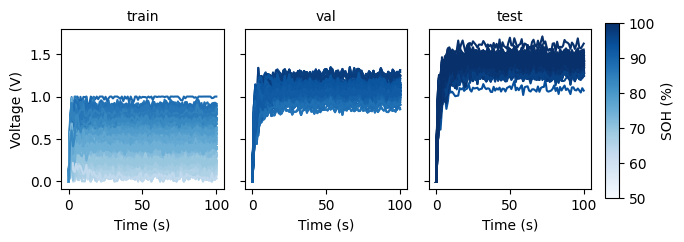

In [ ]:
import matplotlib.pyplot as plt

# Re-apply splits and transforms before saving
fs_charge.clear_splits()
fs_charge.undo_all_transforms()

fs_charge.split_random(
    ratios={"train": 0.6, "val": 0.2, "test": 0.2},
    group_by="group_id",
    seed=42,
)

fs_charge.fit_transform(
    scaler="PerSampleZeroStart",
    domain="features",
    keys="voltage",
    fit_to_split="train",
)
fig, axes = plot_voltages(fs_charge, n_samples=200, rep="transformed")
plt.show()
fs_charge.fit_transform(
    scaler="MinMaxScaler",
    domain="features",
    keys="voltage",
    fit_to_split="train",
)
fig, axes = plot_voltages(fs_charge, n_samples=200, rep="transformed")
plt.show()
fs_charge.fit_transform(
    scaler="MinMaxScaler",
    domain="targets",
    keys="soh",
    fit_to_split="train",
)


In [ ]:
from pathlib import Path
from tempfile import TemporaryDirectory

# Save to temp file
SAVE_DIR = TemporaryDirectory()

save_path = fs_charge.save(Path(SAVE_DIR.name) / "fs_charge_demo", overwrite=True)
print(f"Saved to: {save_path}")

Saved to: /var/folders/21/fsx4ddjs3fg2wgpl7_ksh0k00000gn/T/tmpcnf1i128/fs_charge_demo.fs.mml


Now we can reload this FeatureSet.


Note that ModularML assign all "nodes" in an Experiment a unique ID.
This is important when we move to Experiments and ModelGraphs, but we can just ignore the collision warning for now.

In [ ]:
# Reload from file
fs_rel = FeatureSet.load(save_path)

─────────────────────────────── INFO - Node ID Collision ───────────────────────────────
 Loaded FeatureSet is identical to 'ChargePulses' in the existing ExperimentContext.
 Returning 'FeatureSet(label='ChargePulses', n_samples=508)'.
────────────────────────────────────────────────────────────────────────────────────────


We can pick up exactly where we left off; all history is preserved.

This means we can undo the last transform.

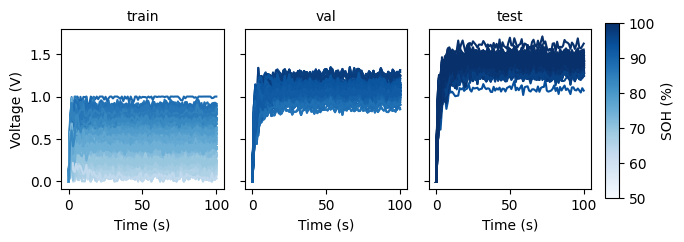

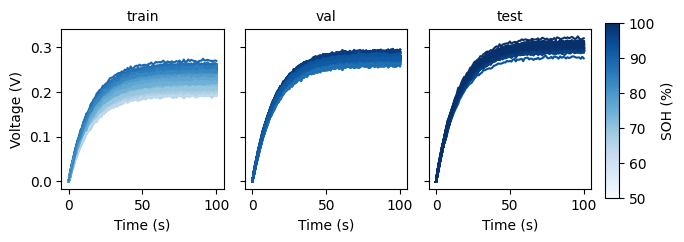

In [ ]:
fig, axes = plot_voltages(fs_rel, n_samples=200, rep="transformed")
plt.show()

fs_rel.undo_last_transform(domain="features")
fig, axes = plot_voltages(fs_rel, n_samples=200, rep="transformed")
plt.show()

### Copying a FeatureSet

Remember that little Node Collision warning?
Well it told us that the loaded FeatureSet was identical to the one in memory, and that instead of loading a copy, it just returned the existing FeatureSet.

That means those last `undo_transforms` call modified our original `fs_charge` FeatureSet too (they're the same object).

While this is great for memory, there are times we'd want to create a copy of a FeatureSet.
This is done with the `.copy()` method.

By default, this also shares internal buffers with the same underlying PyArrow table (i.e., its not a true copy).
Setting `share_raw_data_buffer=False` ensures the new FeatureSet is fully independent of the original.

Note that we can also choose to restore splits and scalers, or just the raw data with the `restore_splits` and `restore_scalers` arguments.

In [ ]:
# Shallow copy with raw data only
fs_copy_raw = fs_charge.copy(label="CopyRawOnly", share_raw_data_buffer=True)
print(f"Copy (raw only) keys: {fs_copy_raw.get_all_keys(include_domain_prefix=True, include_rep_suffix=True)}")
print(f"Copy splits: {fs_copy_raw.available_splits}")

Copy (raw only) keys: ['features.voltage.raw', 'targets.soh.raw', 'tags.cell_id.raw', 'tags.group_id.raw', 'tags.pulse_soc.raw', 'tags.pulse_type.raw', 'sample_id']
Copy splits: []


In [ ]:
# Full copy with splits and scalers restored
fs_copy_full = fs_charge.copy(
    label="CopyFull",
    share_raw_data_buffer=False,
    restore_splits=True,
    restore_scalers=True,
)
print(f"Full copy keys: {fs_copy_full.get_all_keys(include_domain_prefix=True, include_rep_suffix=True)}")
print(f"Full copy splits: {fs_copy_full.available_splits}")

Full copy keys: ['features.voltage.raw', 'features.voltage.transformed', 'targets.soh.raw', 'targets.soh.transformed', 'tags.cell_id.raw', 'tags.group_id.raw', 'tags.pulse_soc.raw', 'tags.pulse_type.raw', 'sample_id']
Full copy splits: ['test', 'train', 'val']


---
## 9. References (for Model Graph Wiring)

When connecting a FeatureSet to a `ModelStage` in a model graph, you create symbolic references rather than passing data directly.

Below is a quick overview, but more details are provided in: 
TODO: $\textcolor{red}{\text{add notebook link}}$

In [ ]:
# Multi-column reference (used for ModelStage inputs)
ref = fs_charge.reference(features="voltage", targets="soh", rep="transformed")
print(f"Reference type: {type(ref).__name__}")
print(f"Reference: {ref}")

Reference type: FeatureSetReference
Reference: FeatureSetReference(node_label='ChargePulses', node_id='a8b09413-1c2c-430c-8065-48b914db41ac', features=('features.voltage.transformed',), targets=('targets.soh.transformed',), tags=('tags.pulse_type.raw', 'tags.group_id.raw', 'tags.cell_id.raw', 'tags.pulse_soc.raw'))


In [ ]:
# Single-column reference (specify rep when multiple representations exist)
col_ref = fs_charge.column_reference(feature="voltage", rep="transformed")
print(f"Column reference type: {type(col_ref).__name__}")
print(f"Column reference: {col_ref}")

Column reference type: FeatureSetColumnReference
Column reference: FeatureSetColumnReference(domain='features', key='voltage', rep='transformed', node_label='ChargePulses', node_id='a8b09413-1c2c-430c-8065-48b914db41ac')


---

## Summary

| Task | Method |
|------|--------|
| Create from dict | `FeatureSet.from_dict(label, data, feature_keys, target_keys, tag_keys)` |
| Create from DataFrame | `FeatureSet.from_pandas(label, df, feature_cols, target_cols, tag_cols, groupby_cols)` |
| Create from Arrow | `FeatureSet.from_pyarrow_table(label, table)` |
| Inspect keys | `get_feature_keys()`, `get_target_keys()`, `get_tag_keys()`, `get_all_keys()` |
| Inspect shapes/dtypes | `get_feature_shapes()`, `get_feature_dtypes()` |
| Get data | `get_features(fmt=...)`, `get_targets(fmt=...)`, `get_tags(fmt=...)` |
| Unified access | `get_data(features=..., targets=..., tags=..., fmt=...)` |
| Filter rows | `filter(conditions={...})` |
| Subset by index | `take(indices)` |
| Select columns | `select(features=..., targets=..., rep=...)` |
| Split randomly | `split_random(ratios, group_by, seed)` |
| Split by condition | `split_by_condition({split_name: {col: condition}})` |
| Apply transform | `fit_transform(scaler, domain, keys, fit_to_split)` |
| Undo transform | `undo_last_transform(domain, keys)` / `undo_all_transforms()` |
| Inverse-scale data | `unscale_data_for_cols(data, domain, columns)` |
| Save / Load | `save(path)` / `FeatureSet.load(path)` |
| Copy | `copy(restore_splits, restore_scalers)` |
| Create reference | `reference(features, targets)` / `column_reference(feature)` |